## Abstract

Un notebook qui présente desprédiction appliquée à une série temporelle en utilisant les méthodes SARIMA. Il conviendra de sélectionner le jeu de fonction idoine, associé à la nature additive ou multiplicative de la situation.

## Bibliothèques utilisées

In [1]:
# Générique data project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

# Pour la manipulation de fichiers
import os
import glob
from pathlib import Path

# Time series
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from sklearn.metrics import mean_squared_error

# MISC
import warnings
warnings.filterwarnings("ignore")
import swifter
import random

## Set up

On récupère les donnée et on transforme en série temporelle

In [2]:
df = pd.read_csv('Month_Value_1.csv')
df = df.dropna()
df

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,01.01.2015,1.601007e+07,12729.0,1257.763541,30024676.0
1,01.02.2015,1.580759e+07,11636.0,1358.507000,30024676.0
2,01.03.2015,2.204715e+07,15922.0,1384.697024,30024676.0
3,01.04.2015,1.881458e+07,15227.0,1235.606705,30024676.0
4,01.05.2015,1.402148e+07,8620.0,1626.621765,30024676.0
...,...,...,...,...,...
59,01.12.2019,5.875647e+07,38069.0,1543.420464,29878525.0
60,01.01.2020,5.628830e+07,27184.0,2070.640850,29044998.0
61,01.02.2020,4.022524e+07,23509.0,1711.057181,29044998.0
62,01.03.2020,5.002217e+07,32569.0,1535.882748,29044998.0


In [3]:
df.set_index('Period',inplace = True)
df.index =  pd.to_datetime(df.index,format='%d.%m.%Y')
df.head()

#%Y-%m-%d

,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
Period,,,,
2015-01-01,1.601007e+07,12729.0,1257.763541,30024676.0
2015-02-01,1.580759e+07,11636.0,1358.507000,30024676.0
2015-03-01,2.204715e+07,15922.0,1384.697024,30024676.0
2015-04-01,1.881458e+07,15227.0,1235.606705,30024676.0
2015-05-01,1.402148e+07,8620.0,1626.621765,30024676.0


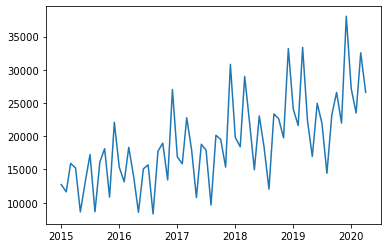

In [4]:
plt.plot(df.Sales_quantity)

## Préparation analyse:

- Objet de l'analyse:


In [5]:
valeur = df.Sales_quantity

- Saisonalité identifiée :

In [6]:
s = 12

- Fin de la série:

In [7]:
end = len(valeur)

- nb de période à vérifier:


In [8]:
a = 10
verif = end -a

## Analyse & Prédictions

On vérifie si on est en présence d'un cas de figure additif ou multiplicatif 

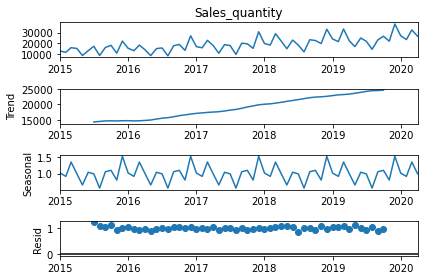

In [9]:
var = seasonal_decompose(valeur,model ='multiplicative')
var.plot()
plt.show()

In [10]:
# Decommenter la ligne idoine:

# Modele additif
#valeur = valeur

# Modele multiplicatif
valeur = np.log(valeur)

On vérifie si la time serie est stationnarisée

In [11]:
_,p_value,_,_,_,_=sm.tsa.stattools.adfuller(valeur)
p_value

0.9811014460604682

On procède à une différenciation de la série temporelle à l'ordre 1:


In [12]:
diff1 = valeur.diff().dropna()

_,p_value,_,_,_,_=sm.tsa.stattools.adfuller(diff1)
p_value

0.0029346027915050188

La valeur de p_value est inférieure à 5%, nous  pouvons rejeter l'hyopthèse que la série n'est pas stationnaire -> docn la série est stationnaire

In [13]:
d = 1
D = 1 # valeur à retenir par essai iteratifs

On définit une fonction qui permet dans la cellule suivante de calculer l'écart entre le réel et le prédit pour plusieurs valeurs p,q,P,Q et qui renvoie in fine la configuration optimale

In [14]:
# Modele additif
'''
def predicat_additif_rmse(w,x,y,z,valeur):
    model = sm.tsa.SARIMAX(valeur,order=(w,d,x),seasonal_order=(y,D,z,s))
    sarima = model.fit()
    pred = sarima.predict(verif,end)
    ech = valeur[verif-1:end]
    RMSE = np.sqrt(mean_squared_error(ech, pred))
    return RMSE

score =[]
trame =[]

for w in range(2):
    for x in range(2):
        for y in range(2):
            for z in range(2):
                score.append(predicat_additif_rmse(w,x,y,z,valeur))
                trame.append((w,x,y,z))
 

trame[score.index(min(score))]

'''

# Modele multiplicatif

def predicat_multi_rmse(w,x,y,z,valeur):
    model = sm.tsa.SARIMAX(valeur,order=(w,d,x),seasonal_order=(y,D,z,s))
    sarima = model.fit()
    pred = np.exp(sarima.predict(verif,end))
    ech = np.exp(valeur[verif-1:end])
    RMSE = np.sqrt(mean_squared_error(ech, pred))
    return RMSE

score =[]
trame =[]

for w in range(2):
    for x in range(2):
        for y in range(2):
            for z in range(2):
                score.append(predicat_multi_rmse(w,x,y,z,valeur))
                trame.append((w,x,y,z))
 

trame[score.index(min(score))]

(0, 0, 1, 1)

On définit une fonction qui permet dans la cellule suivante d'afficher les prédictions pour différentes valeur d'ordre p,q,P,Q de façon à vérifier empiriquement le résultat précédant

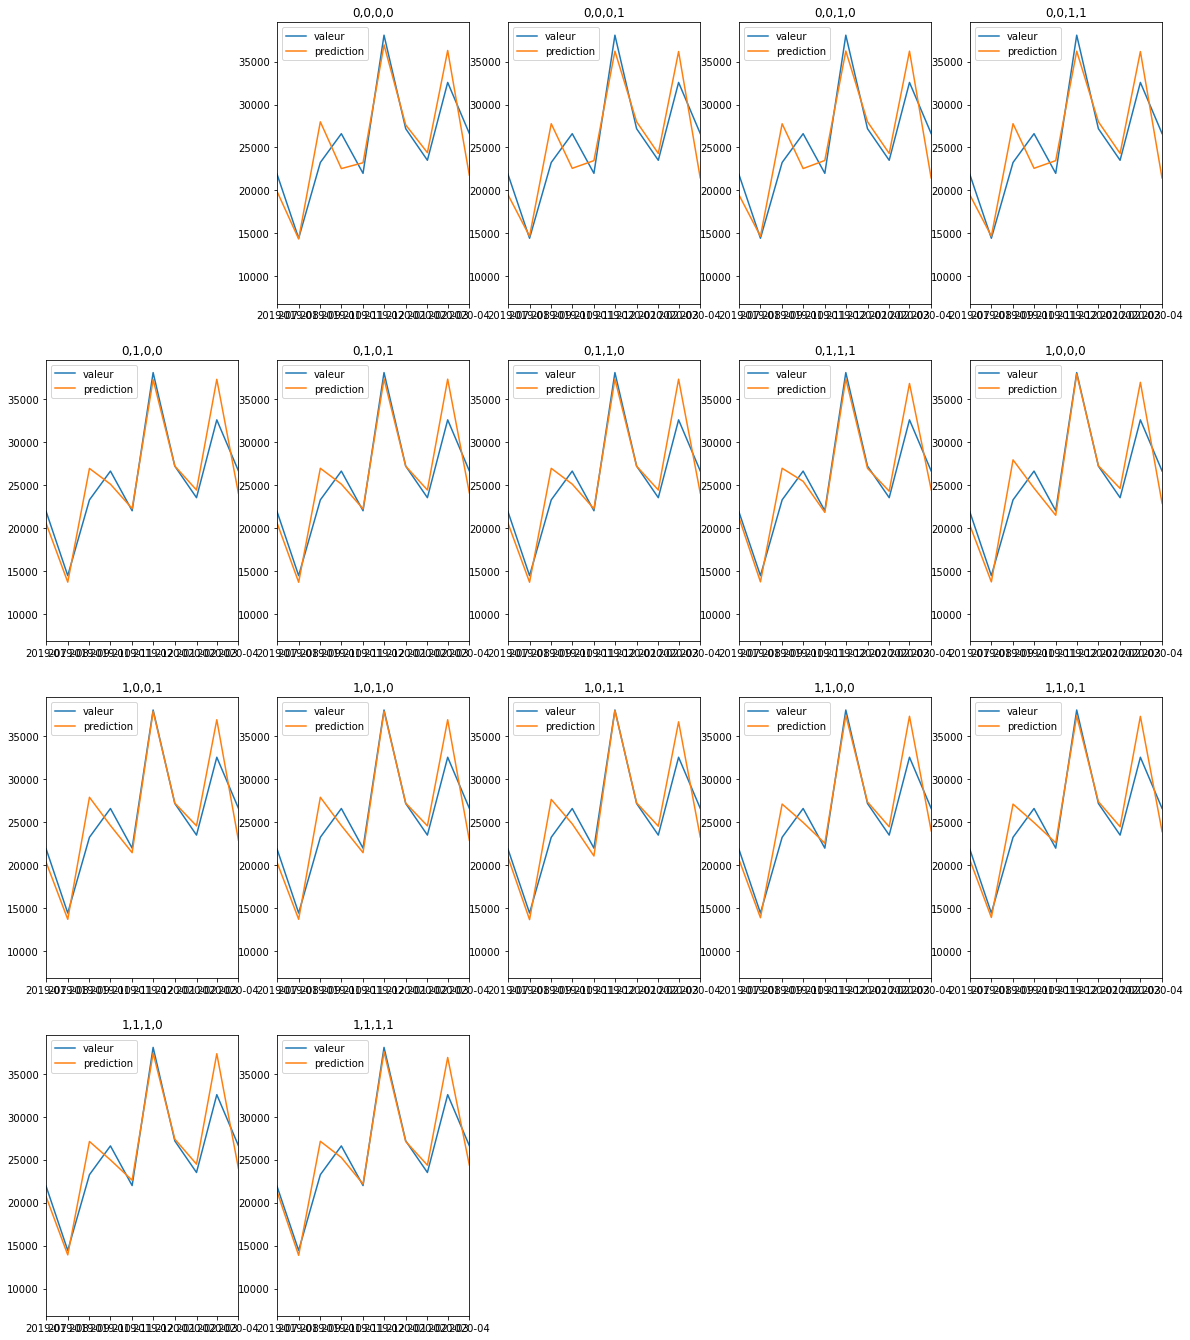

In [15]:
'''
def predicat_additif(w,x,y,z,valeur):
    model = sm.tsa.SARIMAX(valeur,order=(w,1,x),seasonal_order=(y,1,z,s))
    sarima = model.fit()
    pred = sarima.predict(verif,end)
    #dfpred = pd.concat([valeur,pred])
    plt.xlim([valeur.index[verif],valeur.index[end-1]])
    #plt.plot(dfpred)
    plt.plot(valeur,label ='valeur')
    plt.plot(pred,label ='prediction')
    plt.legend()
    
plt.figure(figsize=(20,30))

j = 1
for w in range(2):
    for x in range(2):
        for y in range(2):
            for z in range(2):
                j+=1
                plt.subplot(5,5,j)
                predicat_additif(w,x,y,z,valeur)
                plt.title(f'{w},{x},{y},{z}')
                
plt.show()

'''

def predicat_multi(w,x,y,z,valeur):
    model = sm.tsa.SARIMAX(valeur,order=(w,1,x),seasonal_order=(y,1,z,s))
    sarima = model.fit()
    pred = np.exp(sarima.predict(verif,end))
    #dfpred = pd.concat([valeur,pred])
    plt.xlim([valeur.index[verif],valeur.index[end-1]])
    #plt.plot(dfpred)
    plt.plot(np.exp(valeur),label ='valeur')
    plt.plot(pred,label ='prediction')
    plt.legend()
    
plt.figure(figsize=(20,30))

j = 1
for w in range(2):
    for x in range(2):
        for y in range(2):
            for z in range(2):
                j+=1
                plt.subplot(5,5,j)
                predicat_multi(w,x,y,z,valeur)
                plt.title(f'{w},{x},{y},{z}')
                
plt.show()

On récupère les valeurs, p,q,P,Q optimales

In [16]:
p = trame[score.index(min(score))][0]
q = trame[score.index(min(score))][1]
P = trame[score.index(min(score))][2]
Q = trame[score.index(min(score))][3]

On les utilise pour illustrer une prédiction

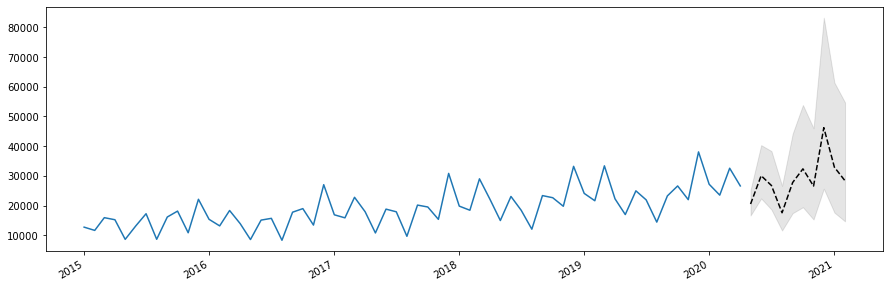

In [17]:
# Modele Additif

'''
model = sm.tsa.SARIMAX(valeur,order=(p,d,q),seasonal_order=(P,D,Q,s))
sarima = model.fit()
prediction = sarima.get_forecast(steps=10).summary_frame()
fig,ax = plt.subplots(figsize=(15,5))
plt.plot(valeur)
prediction['mean'].plot(ax=ax,style ='k--')
ax.fill_between(prediction.index,prediction['mean_ci_lower'],prediction['mean_ci_upper'],color ='k',alpha = 0.1)
'''

# Modele Multiplicatif

model = sm.tsa.SARIMAX(valeur,order=(p,d,q),seasonal_order=(P,D,Q,s))
sarima = model.fit()
prediction = sarima.get_forecast(steps=10).summary_frame()
fig,ax = plt.subplots(figsize=(15,5))
plt.plot(np.exp(valeur))
prediction = np.exp(prediction)
prediction['mean'].plot(ax=ax,style ='k--')
ax.fill_between(prediction.index,prediction['mean_ci_lower'],prediction['mean_ci_upper'],color ='k',alpha = 0.1)